In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from scipy import signal
from sklearn.cross_decomposition import CCA
from scipy.signal import kaiserord, lfilter, firwin, freqz, butter, filtfilt, convolve
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

## Load Dataset

In [2]:
dataset_name = "simulated_recordings/simulated_target_" # 0 to 3
num_targets = 4
targets = [None] * num_targets
channels = ['P7', 'O1', 'O2', 'P8'] # data channels
for i in range(num_targets):
    targets[i] = pd.read_csv(dataset_name+str(i)+'.csv')
    # targets[i]['Unnamed: 0'] = [i % 120 for i in range(len(targets[i].index))]
    # targets[i].rename(columns = {'Unnamed: 0': 'Counter'}, inplace=True)
targets[0].head

<bound method NDFrame.head of        Unnamed: 0  Counter         P7        O1         O2         P8
0               0      NaN  -2.638603 -2.349172  -2.402973  -1.671471
1               1      NaN  -0.365236 -1.520924  -0.404322  -1.788797
2               2      NaN  10.845421  9.150363  10.206743  10.832415
3               3      NaN  -0.447868  0.147212  -1.587292   0.220063
4               4      NaN  -1.076132 -1.962024  -4.082675  -2.966315
...           ...      ...        ...       ...        ...        ...
12795       12795      NaN   7.369919  5.042550   7.630102   6.555047
12796       12796      NaN   4.277316  3.287360   4.122467   2.874881
12797       12797      NaN   5.444024  7.050739   6.952434   4.391041
12798       12798      NaN   2.287735  2.031909   3.070303   3.896144
12799       12799      NaN   6.029772  5.529547   8.690615   7.191785

[12800 rows x 6 columns]>

In [3]:
# check size - make sure each target is the same length
for i in range(num_targets):
    print('length target {} = {}'.format(i, len(targets[i].index)))

length target 0 = 12800
length target 1 = 12800
length target 2 = 12800
length target 3 = 12800


In [4]:
# copy unfiltered data
original_data = [None] * num_targets
for i in range(num_targets):
    original_data[i] = pd.read_csv(dataset_name+str(i)+'.csv')
    original_data[i]['Unnamed: 0'] = [i % 120 for i in range(len(original_data[i].index))]
    original_data[i].rename(columns = {'Unnamed: 0': 'Counter'}, inplace=True)

In [5]:
channels = ['P7', 'O1', 'O2', 'P8']
my_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:cyan', 'tab:gray']
my_labels = ['Target 0', 'Target 1', 'Target 2', 'Target 3', 'Target 4', 'Target 5', 'Target 6', 'Target 7', 'Neutral Target']

def butter_band_targets(targets, low=0.16, high=16.0):
    for i in range(num_targets):
        for channel in channels:
            targets[i][channel] = butter_band(np.asarray(targets[i][channel]), lowcut=low, highcut=high)
    return targets

def butter_highpass_targets(targets):
    for i in range(num_targets):
        for channel in channels:
            targets[i][channel] = butter_highpass(np.asarray(targets[i][channel]))
    return targets

def butter_band(data, s_r=128.0, lowcut=0.16, highcut=50.0, order=5):
    # ------------------------------------------------
    # Create a butterworth bandpass filter and apply it to data.
    # ------------------------------------------------
    nyq = 0.5 * s_r
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    # data = data * 50  # amplify data
    return filtfilt(b, a, data)

def butter_highpass(data, cutoff=0.16, fs=128.0, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

def car_filter_targets(targets):
    # common average reference filter
    # subtract average off all data - list of dataframes
    for i in range(num_targets):
        for channel in channels:
            targets[i][channel] -= np.average(np.asarray(targets[i][channel]))
    return targets

def car_filter_one_channel(data):
    # numpy array - num_samples in one channel
    return data - np.average(data)

In [6]:
def cut_uneven_datasets(df_list):
    # use this function if the datasets are of uneven length - chop to minimum df size
    cutoff_list = [len(df_list[i].index) for i in range(8)]
    cutoff = min(cutoff_list)
    for i in range(len(cutoff_list)):
        keep_indicies = set(range(df_list[i].shape[0])) - set(range(cutoff, df_list[i].shape[0]))
        df_list[i] = df_list[i].take(list(keep_indicies))
        # make sure each df same length
        print('length of dataset {} = {}'.format(i+1, len(templates[i].index)))



# these filtering functions work on each target - only call once
def pca_filter(variance=0.2):
    for i in range(num_targets):
        pca = PCA(variance).fit(targets[i][channels])
        components = pca.transform(targets[i][channels])
        targets[i][channels] = pd.DataFrame(pca.inverse_transform(components))
        
def fir_filter(frequencies=None):
    # if frequencies are not supplied, assume 1 to 50 Hz. Otherwise filter for the target frequency - cheating
    if frequencies is None:
        filt = signal.firwin(400, [3.0, 50.0], pass_zero=False, fs=128.0)
        for i in range(num_targets):
            for channel in channels:
                targets[i][channel] = signal.convolve(np.array(targets[i][channel]), filt, mode='same')
    # trying to filter each channel based on respective target frequencies
    else:
        for i in range(num_targets):
            band_edges = [frequencies[i]-1.0, frequencies[i]+1.0]
            print(band_edges)
            for channel in channels:
                filt = signal.firwin(400, band_edges, pass_zero=False, fs=128.0)
                targets[i][channel] = signal.convolve(targets[i][channel], filt, mode='same')
            
        
def plot_time_all(data, start=0, end=1000, extend_title=''):
    # df plot
    for i in range(num_targets):
        fig, ax = plt.subplots(figsize=(10, 5))
        for channel in channels:
            data[i][channel][start:end].plot(y=channel, title='Target {} Signal Over Time {}'.format(i, extend_title) if i != 8 else 'Neutral Target Signal')
        ax.legend(channels)
        ax.autoscale(axis='y', tight=True)
        
        
def plot_channel(target, channel):
    # assume dataframe
    fig, ax = plt.subplots(figsize=(10, 5))
    target[channel].plot(y=channel, title='{} Signal Over Time'.format(channel))
        
def cut_ends(cutoff=256):
    # this function is used after FIR filtering because the ends have extremely high peaks
    n = len(targets[0].index)
    ind = [i for i in range(cutoff)] + [i for i in range(n-1, n-cutoff-1, -1)]
    for i in range(num_targets):
        targets[i].drop(index=ind, inplace=True)
        targets[i].reset_index(drop=True, inplace=True)
        
def cut_left_end(cutoff=256):
    n = len(targets[0].index)
    ind = [i for i in range(cutoff)]
    for i in range(num_targets):
        targets[i].drop(index=ind, inplace=True)
        targets[i].reset_index(drop=True, inplace=True)

In [7]:
# plot_time_all(targets, extend_title='- Unfiltered')

In [8]:
frequencies = [15.0, 12.0, 8.57, 5.45]
targets = car_filter_targets(targets)
targets = butter_highpass_targets(targets)
# targets = butter_band_targets(targets)

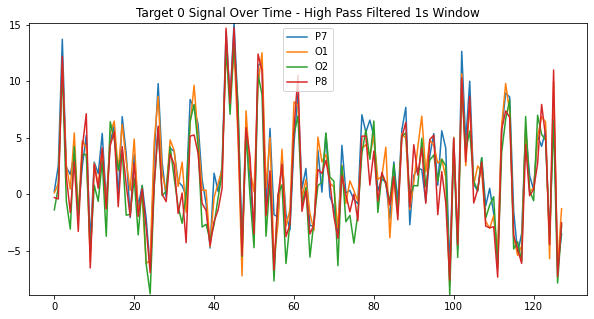

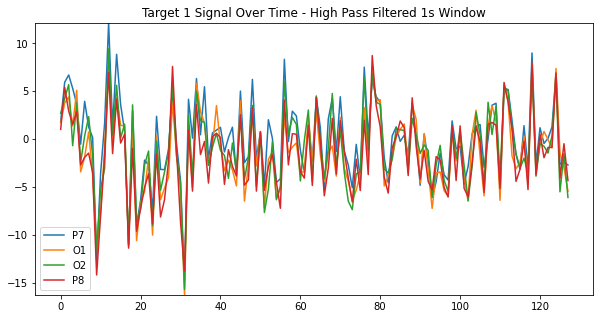

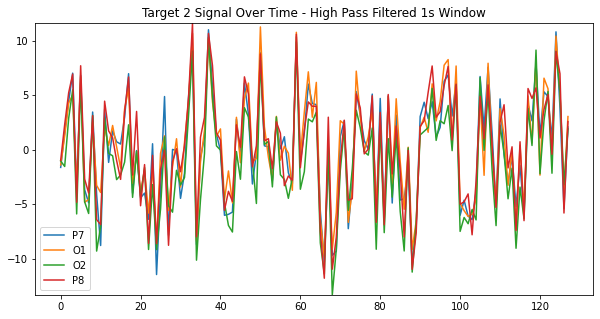

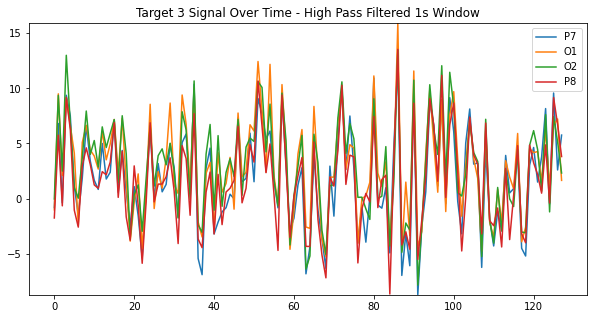

In [9]:
plot_time_all(targets, start=0, end=128, extend_title='- High Pass Filtered 1s Window')

In [10]:
# plot_time_all(targets, extend_title='- High Pass Filtered')

In [11]:
def getReferenceSignals(frequencies, num_seconds):
    ref_signals = []
    for freq in frequencies:
        ref_signals.append(generateRefSignal(128 * num_seconds, freq))
    return np.asarray(ref_signals)

def generateRefSignal(samples, freq):
    signals = []
    t = np.arange(0, (samples/128.0), step=1.0/128.0)
    signals.append(np.sin(np.pi*2*freq*t))
    signals.append(np.cos(np.pi*2*freq*t))
    signals.append(np.sin(np.pi*4*freq*t))
    signals.append(np.cos(np.pi*4*freq*t))

    return np.asarray(signals)

def findCorr(data, target):
    result = np.zeros([(target.shape)[0], 2]) # num_targets x number of canonical corrs
    cca = CCA(n_components=2)
    for i in range(0, (target.shape)[0]):
        cca.fit(data, np.squeeze(target[i,:,:]).T)
        a, b = cca.transform(data, np.squeeze(target[i,:,:]).T)
        # a and b shape = 128 x (n_components)
        # print('a shape {} \t b shape {}'.format(a.shape, b.shape))
        corr_arr0 = np.corrcoef(a[:,0], b[:,0])
        corr_arr1 = np.corrcoef(a[:,1], b[:,1])
        # print('target {}:\tcorr={}'.format(i, corr_arr0[0, 1]))
        # print('target {}:\tcorr0 = {}\tcorr1 = {}'.format(i, corr_arr0[0,1], corr_arr1[0,1]))
        corr = corr_arr0[0, 1]
        corr2 = corr_arr1[0, 1]
        result[i][0] = corr
        result[i][1] = corr2
    return result

def getChunkFeatures(data, ref_signals):
    corrs = findCorr(data, ref_signals)
    # print(corrs.flatten())
    return corrs.flatten(order='F')

In [20]:
def check_targets(num_seconds=2, cheating=False):
    # taking raw data from EEG, filtering it, making predictions, and generating CCA features
    num_chunks = len(original_data[0].index) // (128 * num_seconds)
    features = np.zeros([num_chunks * num_targets, 9])
    ref_signals = getReferenceSignals(frequencies, num_seconds=num_seconds)
    channels = ['P7', 'O1', 'O2', 'P8']
    chunk = 0
    for target in range(len(original_data)):
        predictions = []
        row = 0
        # print('\n' + '-'*20 + 'Checking Target {} against reference signals ... '.format(target) + '-'*20 + '\n')
        while True:
            if row >= len(original_data[target].index) or len(original_data[target].index) - row < 128 * num_seconds:
                # print("done checking targets. row at {}".format(row))
                break
            # print('Checking samples {} to {} ...'.format(row, row+128*num_seconds))
            data = np.asarray(original_data[target][channels][row:row+128*num_seconds]) # 128 x 4
            
            # filter chunk
            for i, channel in enumerate(data.T):
                
                if cheating:
                    band_edges = [frequencies[target] - 1.0, frequencies[target] + 1.0]
                    data.T[i] = butter_band(channel, lowcut=band_edges[0], highcut=band_edges[1])
                else:
                    # data.T[i] = butter_filter(channel)
                    channel = car_filter_one_channel(channel)
                    data.T[i] = butter_highpass(channel)
                    # channel = car_filter_one_channel(channel)
                    # data.T[i] = butter_band(channel, lowcut=0.16, highcut=30.0)

            features_row = getChunkFeatures(data, ref_signals)
            features_row = np.append(features_row, target)
            features[chunk] = features_row
            prediction = np.argmax(features_row[:4])
            # print("Predicted target {}".format(prediction))
            predictions.append(prediction)
            row += 128 * num_seconds
            chunk += 1
        accuracy = round(100 * predictions.count(target) / len(predictions))
        print('Accuracy for target {} against target {} reference signals = {} %'.format(target, target, accuracy))
    return features

In [21]:
def get_knn_accuracy(num_seconds, cheating=False):
    features = check_targets(num_seconds=num_seconds, cheating=cheating)
    # print('-'*20 + 'Performing KNN with {} second segments... '.format(num_seconds) + '-'*20)
    corrs = features[:, :-1]
    labels = [int(i) for i in features[:, -1]]
    X_train, X_test, y_train, y_test = train_test_split(corrs, labels, test_size=0.20, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    print('KNN Accuracy for {} seconds: '.format(num_seconds), metrics.accuracy_score(y_test, pred))
    # print('Predicted actions:')
    # print([int(i) for i in pred])
    # print('Correct actions:')
    # print([int(i) for i in y_test])
    print('\n')

In [22]:
get_knn_accuracy(num_seconds=1)
get_knn_accuracy(num_seconds=2)
get_knn_accuracy(num_seconds=3)

Accuracy for target 0 against target 0 reference signals = 72 %
Accuracy for target 1 against target 1 reference signals = 60 %
Accuracy for target 2 against target 2 reference signals = 71 %
Accuracy for target 3 against target 3 reference signals = 62 %
KNN Accuracy:  0.575


Accuracy for target 0 against target 0 reference signals = 94 %
Accuracy for target 1 against target 1 reference signals = 84 %
Accuracy for target 2 against target 2 reference signals = 94 %
Accuracy for target 3 against target 3 reference signals = 94 %
KNN Accuracy:  0.925


Accuracy for target 0 against target 0 reference signals = 97 %
Accuracy for target 1 against target 1 reference signals = 97 %
Accuracy for target 2 against target 2 reference signals = 100 %
Accuracy for target 3 against target 3 reference signals = 100 %
KNN Accuracy:  0.9629629629629629


